# Experiments B: RNN:
Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

In [1]:
# import packages
from packaging import version
import numpy as np
import re
import string
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import keras
from keras import layers
import time

import nltk
from nltk.corpus import stopwords

tf.random.set_seed(7)

2024-05-12 22:44:55.482192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 22:44:55.482316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 22:44:55.596895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
import matplotlib.pyplot as plt
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [3]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [4]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

W0512 22:45:09.364371 136315243833152 download_and_prepare.py:46] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
2024-05-12 22:45:09.688388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 22:45:09.688441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 22:45:09.689822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO[utils.py]: NumExpr defaulting to 4 threads.
INFO[dataset_info.py]: Load pre-computed Data

In [5]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Unidirectional RNN (1)

In [6]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.SimpleRNN(32)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop",
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,380 (1.01 MB)

 Trainable params: 265,380 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
t0 = time.time()
history1 = model1.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time1 = time.time()-t0
pred1 = model1.evaluate(int_test_ds)
print(f"Test acc: {pred1[1]:.3f}")

Epoch 1/10
   3/3563 ━━━━━━━━━━━━━━━━━━━━ 3:30 59ms/step - accuracy: 0.2517 - loss: 1.4225

I0000 00:00:1715554007.966359     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3563/3563 ━━━━━━━━━━━━━━━━━━━━ 204s 56ms/step - accuracy: 0.2499 - loss: 1.3932 - val_accuracy: 0.2497 - val_loss: 1.3869
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 195s 55ms/step - accuracy: 0.2528 - loss: 1.3869 - val_accuracy: 0.2515 - val_loss: 1.3867
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 196s 55ms/step - accuracy: 0.2544 - loss: 1.3869 - val_accuracy: 0.2515 - val_loss: 1.3866
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 196s 55ms/step - accuracy: 0.2522 - loss: 1.3866 - val_accuracy: 0.2557 - val_loss: 1.3867
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 196s 55ms/step - accuracy: 0.2532 - loss: 1.3876 - val_accuracy: 0.2440 - val_loss: 1.3903
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 197s 55ms/step - accuracy: 0.2537 - loss: 1.3871 - val_accuracy: 0.2515 - val_loss: 1.3866
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 200s 56ms/step - accuracy: 0.2546 - loss: 1.3865 - val_accuracy: 0.2515 - val_loss: 1.3865
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 196s 55ms/step - accuracy: 0.2533 - lo

# Unidirectional RNN (2)

In [8]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.SimpleRNN(64)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer="rmsprop",
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,804 (1.06 MB)

 Trainable params: 276,804 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
t0 = time.time()
history2 = model2.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time2 = time.time()-t0
pred2 = model2.evaluate(int_test_ds)
print(f"Test acc: {pred2[1]:.3f}")

Epoch 1/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 117s 32ms/step - accuracy: 0.2504 - loss: 1.3963 - val_accuracy: 0.2515 - val_loss: 1.3866
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 137s 31ms/step - accuracy: 0.2544 - loss: 1.3882 - val_accuracy: 0.2515 - val_loss: 1.3868
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 108s 30ms/step - accuracy: 0.2506 - loss: 1.3899 - val_accuracy: 0.2823 - val_loss: 1.3837
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - accuracy: 0.2559 - loss: 1.3894 - val_accuracy: 0.2465 - val_loss: 1.3886
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - accuracy: 0.2522 - loss: 1.3901 - val_accuracy: 0.2515 - val_loss: 1.3876
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.2524 - loss: 1.3900 - val_accuracy: 0.2582 - val_loss: 1.3872
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - accuracy: 0.2535 - loss: 1.3900 - val_accuracy: 0.2575 - val_loss: 1.3864
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.

# Unidirectional RNN (3)

In [20]:
from keras import regularizers
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.SimpleRNN(64,recurrent_regularizer=regularizers.l2(1e-3))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer="rmsprop",
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,804 (1.06 MB)

 Trainable params: 276,804 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
t0 = time.time()
history3 = model3.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time3 = time.time()-t0
pred3 = model3.evaluate(int_test_ds)
print(f"Test acc: {pred3[1]:.3f}")

Epoch 1/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.2503 - loss: 1.4181 - val_accuracy: 0.2515 - val_loss: 1.3871
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.2524 - loss: 1.3874 - val_accuracy: 0.2515 - val_loss: 1.3872
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.2523 - loss: 1.3871 - val_accuracy: 0.2515 - val_loss: 1.3867
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.2524 - loss: 1.3868 - val_accuracy: 0.2515 - val_loss: 1.3868
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.2551 - loss: 1.3867 - val_accuracy: 0.2515 - val_loss: 1.3871
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.2519 - loss: 1.3867 - val_accuracy: 0.2515 - val_loss: 1.3869
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.2525 - loss: 1.3867 - val_accuracy: 0.2515 - val_loss: 1.3866
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.2522 -

# Bidirectional RNN (1) 

In [14]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer="rmsprop",
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model4.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,756 (1.05 MB)

 Trainable params: 274,756 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
t0 = time.time()
history4 = model4.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time4 = time.time()-t0
pred4 = model4.evaluate(int_test_ds)
print(f"Test acc: {pred4[1]:.3f}")

Epoch 1/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 247s 68ms/step - accuracy: 0.7063 - loss: 0.7648 - val_accuracy: 0.8482 - val_loss: 0.4430
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 254s 67ms/step - accuracy: 0.8352 - loss: 0.4860 - val_accuracy: 0.8437 - val_loss: 0.4471
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 233s 65ms/step - accuracy: 0.8415 - loss: 0.4677 - val_accuracy: 0.8488 - val_loss: 0.4283
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 232s 65ms/step - accuracy: 0.8466 - loss: 0.4530 - val_accuracy: 0.8465 - val_loss: 0.4411
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 232s 57ms/step - accuracy: 0.8503 - loss: 0.4446 - val_accuracy: 0.8483 - val_loss: 0.4369
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 290s 65ms/step - accuracy: 0.8537 - loss: 0.4366 - val_accuracy: 0.8458 - val_loss: 0.4493
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 258s 64ms/step - accuracy: 0.8563 - loss: 0.4272 - val_accuracy: 0.8453 - val_loss: 0.4400
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 225s 63ms/step - accuracy: 

# Bidirectional RNN (2) 

In [16]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(64))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model5 = tf.keras.Model(inputs, outputs)
model5.compile(optimizer="rmsprop",
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model5.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,604 (1.14 MB)

 Trainable params: 297,604 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
t0 = time.time()
history5 = model5.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time5 = time.time()-t0
pred5 = model5.evaluate(int_test_ds)
print(f"Test acc: {pred5[1]:.3f}")

Epoch 1/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 161s 44ms/step - accuracy: 0.7121 - loss: 0.7367 - val_accuracy: 0.8420 - val_loss: 0.4590
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 182s 39ms/step - accuracy: 0.8328 - loss: 0.4832 - val_accuracy: 0.8533 - val_loss: 0.4201
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - accuracy: 0.8424 - loss: 0.4560 - val_accuracy: 0.8488 - val_loss: 0.4268
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - accuracy: 0.8464 - loss: 0.4429 - val_accuracy: 0.8528 - val_loss: 0.4223
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 130s 37ms/step - accuracy: 0.8518 - loss: 0.4273 - val_accuracy: 0.8430 - val_loss: 0.4565
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 129s 33ms/step - accuracy: 0.8556 - loss: 0.4188 - val_accuracy: 0.8448 - val_loss: 0.4395
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 124s 35ms/step - accuracy: 0.8593 - loss: 0.4100 - val_accuracy: 0.8465 - val_loss: 0.4362
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 144s 35ms/step - accuracy: 

# Bidirectional RNN (3) 

In [22]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(64,recurrent_regularizer=regularizers.l2(1e-3)))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model6 = tf.keras.Model(inputs, outputs)
model6.compile(optimizer="rmsprop",
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model6.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, None, 256)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,604 (1.14 MB)

 Trainable params: 297,604 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
t0 = time.time()
history6 = model6.fit(int_train_ds, validation_data=int_val_ds, epochs=10, batch_size = 35)
training_time6 = time.time()-t0
pred6 = model6.evaluate(int_test_ds)
print(f"Test acc: {pred6[1]:.3f}")

Epoch 1/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 136s 37ms/step - accuracy: 0.7020 - loss: 0.8355 - val_accuracy: 0.8477 - val_loss: 0.4871
Epoch 2/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 103s 29ms/step - accuracy: 0.8348 - loss: 0.5132 - val_accuracy: 0.8490 - val_loss: 0.4637
Epoch 3/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.8433 - loss: 0.4779 - val_accuracy: 0.8498 - val_loss: 0.4698
Epoch 4/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - accuracy: 0.8490 - loss: 0.4599 - val_accuracy: 0.8457 - val_loss: 0.4644
Epoch 5/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 97s 27ms/step - accuracy: 0.8518 - loss: 0.4445 - val_accuracy: 0.8510 - val_loss: 0.4543
Epoch 6/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - accuracy: 0.8564 - loss: 0.4367 - val_accuracy: 0.8480 - val_loss: 0.4638
Epoch 7/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.8589 - loss: 0.4291 - val_accuracy: 0.8497 - val_loss: 0.4548
Epoch 8/10
3563/3563 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.863

# Visualization

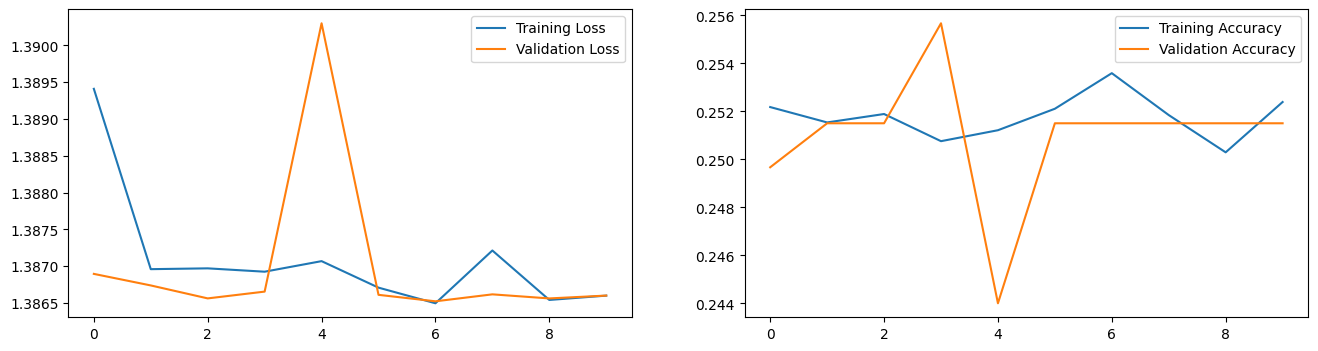

In [26]:
plot_history(history1)

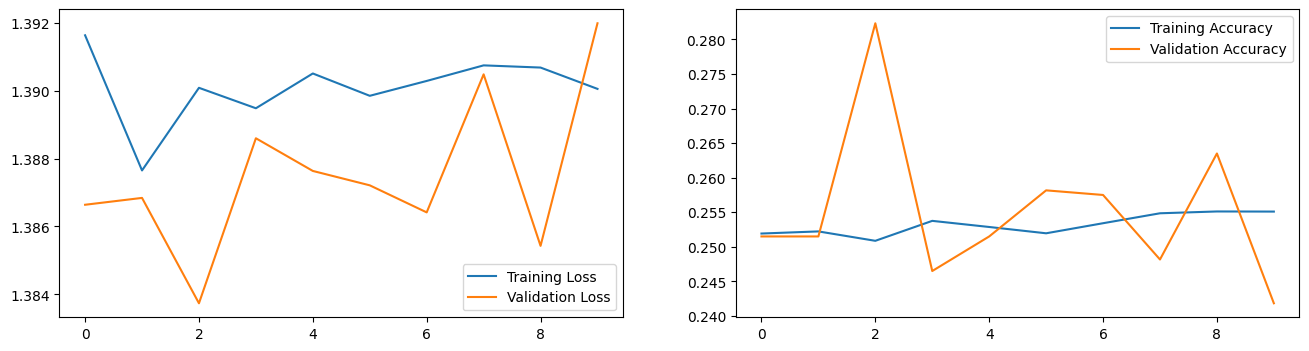

In [27]:
plot_history(history2)

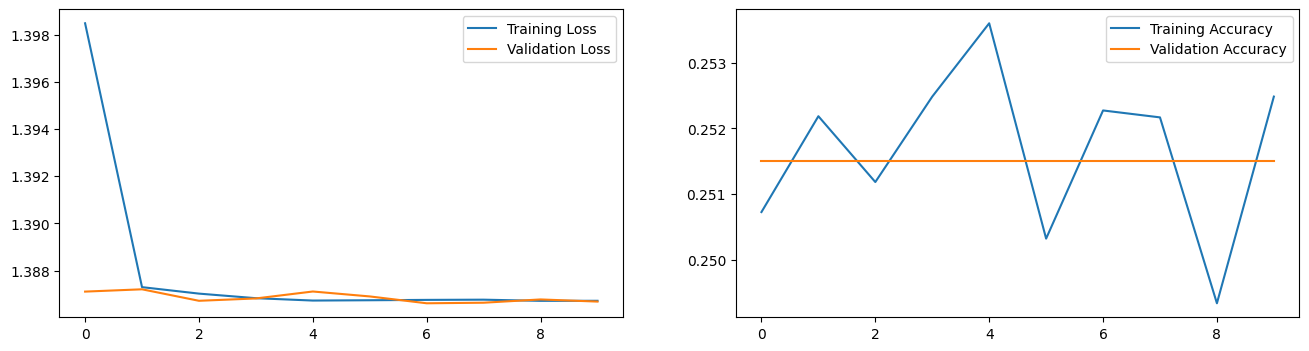

In [28]:
plot_history(history3)

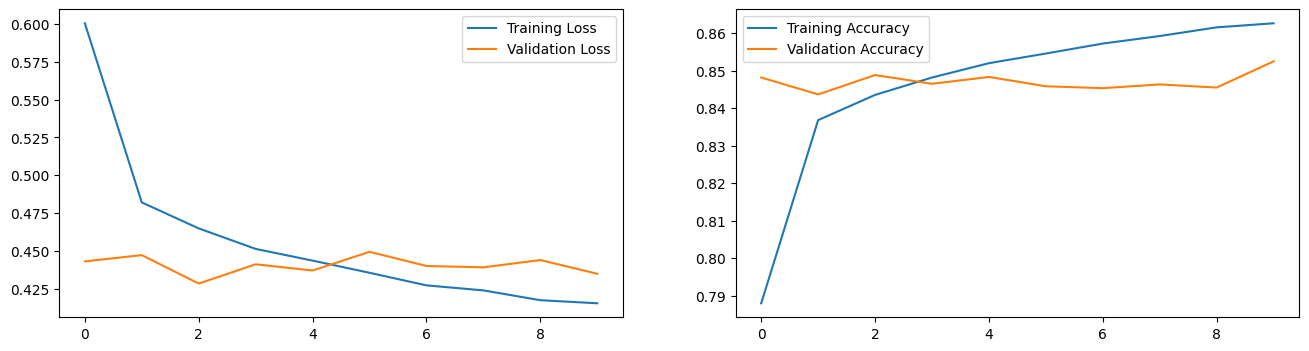

In [29]:
plot_history(history4)

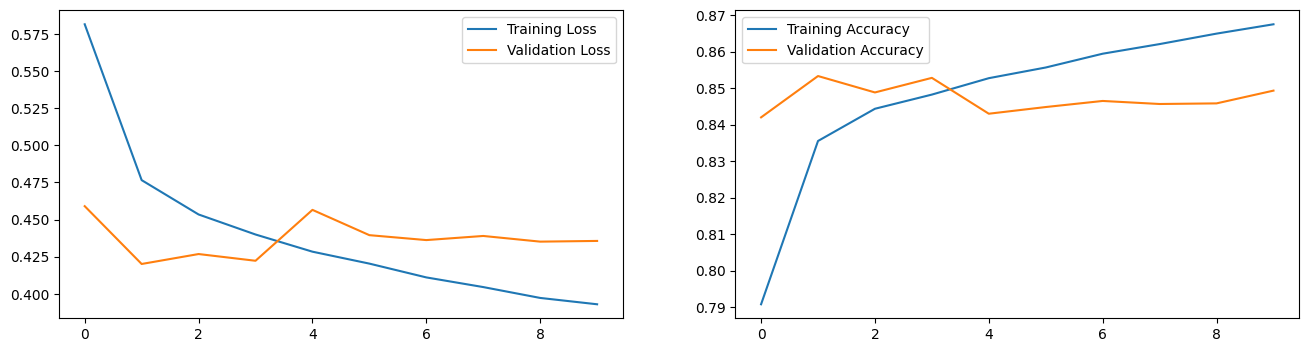

In [30]:
plot_history(history5)

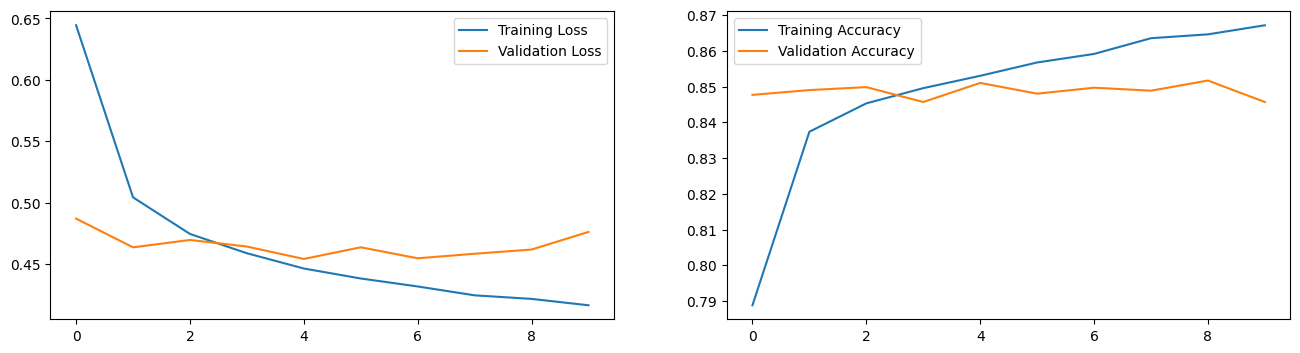

In [31]:
plot_history(history6)

# Result

In [32]:
list1= [history1.history['accuracy'][-1],history1.history['loss'][-1],
        history1.history['val_accuracy'][-1],history1.history['val_loss'][-1],
        pred1[0],pred1[1],training_time1]
list2= [history2.history['accuracy'][-1],history2.history['loss'][-1],
        history2.history['val_accuracy'][-1],history2.history['val_loss'][-1],
        pred2[0],pred2[1],training_time2]

list3= [history3.history['accuracy'][-1],history3.history['loss'][-1],
        history3.history['val_accuracy'][-1],history3.history['val_loss'][-1],
        pred3[0],pred3[1],training_time3]

list4= [history4.history['accuracy'][-1],history4.history['loss'][-1],
        history4.history['val_accuracy'][-1],history4.history['val_loss'][-1],
        pred4[0],pred4[1],training_time4]
list5= [history5.history['accuracy'][-1],history5.history['loss'][-1],
        history5.history['val_accuracy'][-1],history5.history['val_loss'][-1],
        pred5[0],pred5[1],training_time5]
list6= [history6.history['accuracy'][-1],history6.history['loss'][-1],
        history6.history['val_accuracy'][-1],history6.history['val_loss'][-1],
        pred6[0],pred6[1],training_time6]

In [34]:
import pandas as pd
results = [list1, list2, list3,list4,list5,list6]
columns = ['training_accuracy','training_loss','val_accuracy','val_loss','testing_loss','testing_accuracy','training_time']
row_names = ['RNN unidirectional 32 neurons','RNN unidirectional 64 neurons','RNN unidirectional 64 neurons with L2',
             'RNN unidirectional 32 neurons','RNN unidirectional 64 neurons','RNN unidirectional 64 neurons with L2']

# Create the DataFrame
results_df = pd.DataFrame(results, columns=columns,index = row_names)
results_df


,training_accuracy,training_loss,val_accuracy,val_loss,testing_loss,testing_accuracy,training_time
RNN unidirectional 32 neurons,0.252386,1.386601,0.251500,1.386601,1.386601,0.250000,1981.924889
RNN unidirectional 64 neurons,0.255096,1.390054,0.241833,1.391987,1.390807,0.238816,1180.390704
RNN unidirectional 64 neurons with L2,0.252482,1.386720,0.251500,1.386687,1.386753,0.250000,534.962417
RNN unidirectional 32 neurons,0.862649,0.415259,0.852500,0.434784,0.435268,0.850921,2413.782645
RNN unidirectional 64 neurons,0.867526,0.392947,0.849333,0.435614,0.442225,0.846842,1422.555991
RNN unidirectional 64 neurons with L2,0.867114,0.416601,0.845667,0.476308,0.473820,0.846184,1148.312055


In [35]:
results_df.to_excel("results1.xlsx")